## 以下範例用於簡化蒙地卡羅法與凸函數優化

In [26]:
import six
from abc import ABCMeta, abstractmethod
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#假設人平均活75年，也就是27375天
K_INIT_LIVING_DAYS = 27375

# 人的類別
class Person(object):
    def __init__(self):
        # 初始化壽命
        self.living = K_INIT_LIVING_DAYS
        # 初始化幸福指數
        self.happiness = 0
        # 初始化財富指數
        self.wealth = 0
        # 初始化名望權力
        self.fame = 0
        # 活著的第幾天
        self.living_day = 0
    
    def live_one_day(self, seek):
        """
            每天只能做一件事來追求幸福，
            seek決定你追求什麼
            seek是BaseSeekDay類別
        """
        consume_living, happiness, wealth, fame = seek.do_seek_day()
        self.living -= consume_living
        self.happiness += happiness
        self.wealth += wealth
        self.fame += fame
        self.living_day += 1
        
# 追求幸福的類別
class BaseSeekDay(six.with_metaclass(ABCMeta, object)):
    """
    每一種「追求 seek」的基底類別，例如：
    - 健康
    - 愛情
    - 金錢
    - 名望
    不同追求會有不同的固定常數與可變因子序列。
    """

    def __init__(self):
        # 每個 seek 每天消耗生命的常數
        self.living_consum = 0
        # 每個 seek 每天增加的幸福指數常數
        self.happiness_base = 0
        # 每個 seek 每天增加的財富指數常數
        self.wealth_base = 0
        # 每個 seek 每天增加的名望權力指數常數
        self.fame_base = 0

        # 每天生命消耗的可變因子序列
        self.living_factor = [0]
        # 每天幸福指數的可變因子序列
        self.happiness_factor = [0]
        # 每天財富增加的可變因子序列
        self.wealth_factor = [0]
        # 每天名望權力增加的可變因子序列
        self.fame_factor = [0]

        # 已追求的天數
        self.do_seek_day_cnt = 0

        # 由子類別設定自己的常數與可變因素序列
        self._init_self()

    # -------------------------------------------------------
    # 子類別必須實作以下兩個 abstract method
    # -------------------------------------------------------

    @abstractmethod
    def _init_self(self, *args, **kwargs):
        """
        子類別必須實作：
        設定自己的固定常數（living_consum, happiness_base ...）
        與可變因子序列（living_factor, happiness_factor ...）
        """
        pass

    @abstractmethod
    def _gen_living_days(self, *args, **kwargs):
        """
        子類別可以依需求生成可變因子序列
        （例如健康會從負值 → 正值，金錢可能持續上升等等）
        """
        pass

    # -------------------------------------------------------
    # 每一天的 seek 計算
    # -------------------------------------------------------

    def do_seek_day(self):
        """
        執行一天的 seek：
        回傳 (生命消耗, 幸福增加, 財富增加, 名望增加)
        """

        idx = self.do_seek_day_cnt  # 獲取今天的索引

        # 1) 計算生命消耗
        if idx >= len(self.living_factor):
            consume_living = self.living_factor[-1] * self.living_consum
        else:
            consume_living = self.living_factor[idx] * self.living_consum

        # 2) 計算幸福
        if idx >= len(self.happiness_factor):
            happiness = self.happiness_factor[-1] * self.happiness_base
        else:
            happiness = self.happiness_factor[idx] * self.happiness_base

        # 3) 計算財富
        if idx >= len(self.wealth_factor):
            wealth = self.wealth_factor[-1] * self.wealth_base
        else:
            wealth = self.wealth_factor[idx] * self.wealth_base

        # 4) 計算名望
        if idx >= len(self.fame_factor):
            fame = self.fame_factor[-1] * self.fame_base
        else:
            fame = self.fame_factor[idx] * self.fame_base

        # 記錄追求天數增加
        self.do_seek_day_cnt += 1

        return consume_living, happiness, wealth, fame

In [28]:
def regular_mm(group):
    """最小–最大正規化"""
    return (group - group.min()) / (group.max() - group.min())


class HealthSeekDay(BaseSeekDay):
    """
    HealthSeekDay：追求健康長壽的一天
    形象：運動、旅遊、娛樂、做自己感興趣的事
    抽象：追求健康與生命延展
    """

    def _init_self(self):
        # 每天對生命影響的常數 = 1（代表消耗 1 天）
        self.living_consum = 1
        # 每天幸福增加常數 = 1
        self.happiness_base = 1

        # 產生可變因子序列
        self._gen_living_days()

    def _gen_living_days(self):
        """
        建立生命消耗與幸福變化的可變序列
        """

        # 只生成 12000 天（幸福感會逐漸下降至 0）
        days = np.arange(1, 12000)

        # 基底函式取 sqrt，控制生命影響變化速度
        living_days = np.sqrt(days)

        """
        生命因子：
        正規化到 -1～1 之間
        代表：
        ─ 一開始（追求次數少）對生命有正面效果（延長生命）
        ─ 隨著追求次數增加，最終會轉為消耗生命（自然死亡不可避免）
        """
        self.living_factor = regular_mm(living_days) * 2 - 1

        """
        幸福因子：
        正規化到 1～0 之間，由高 → 低
        代表：
        ─ 一開始做這件事非常幸福
        ─ 做太多次後變麻木，不再帶來幸福
        """
        self.happiness_factor = regular_mm(days)[::-1]


只追求健康長壽快樂活了97.12年，幸福指數5999.5,財富累積0,名望權力0


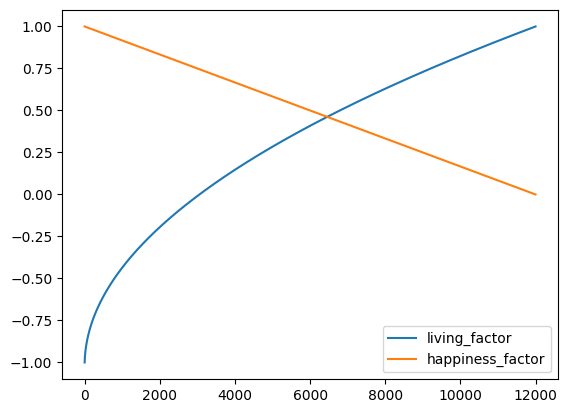

In [29]:
# 初始化我
me = Person()
# 初始化追求健康的一天
seek_health = HealthSeekDay()
while me.living > 0:
    # 只要活著就只追求健康
    me.live_one_day(seek_health)
print('只追求健康長壽快樂活了{}年，幸福指數{},財富累積{},名望權力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

plt.plot(seek_health.living_factor * seek_health.living_consum)
plt.plot(seek_health.happiness_factor * seek_health.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')